# Load dataset

In [7]:
raw_data = read.csv("final_cleaned_data.csv")

### Make a copy, just so we keep the raw data untouched 

In [8]:
filtered_data = data.frame(raw_data)

### Filter out annual and bianuual seasonalites (by using a band filter)

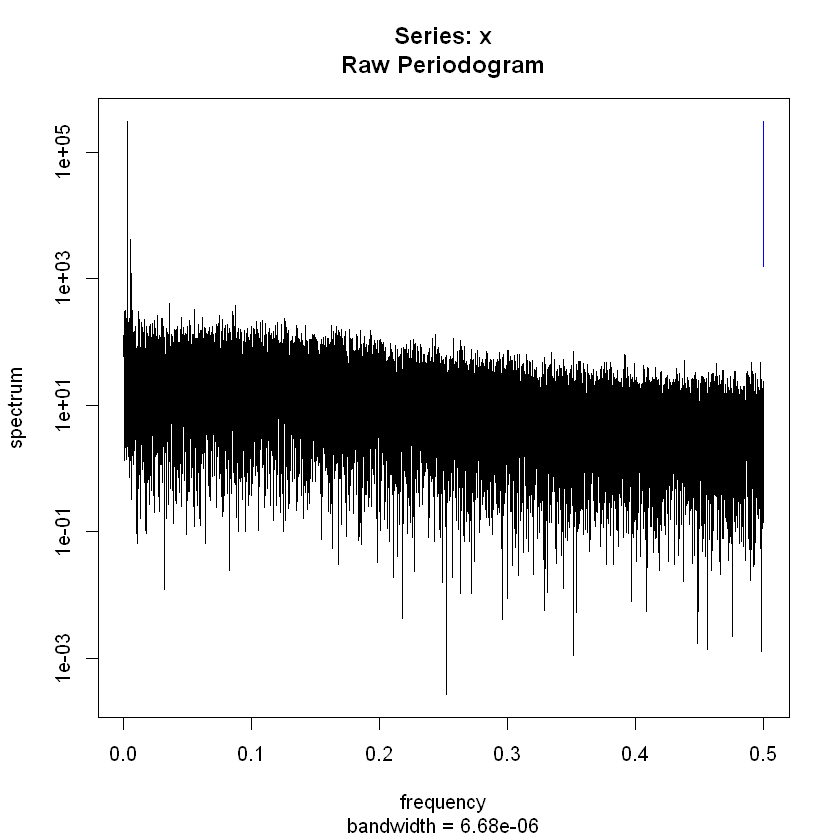

In [9]:
spectrum(filtered_data$MaxTemp)

Clearly there are a few spikes indicating strong annual and biannual seasonality.

In [10]:
# Oscillations to be subtracted
annual_osc = spectral::filter.fft(filtered_data$MaxTemp, x = NULL, fc = 0.002725, BW = 0.00105, n = 2)
biannual_osc = spectral::filter.fft(filtered_data$MaxTemp, x = NULL, fc = 0.00545, BW = 0.0002, n = 2)

# This is for recovering original data
imaginary_residuals = Im(filtered_data$MaxTemp - annual_osc - biannual_osc)

# This is for further processing
filtered_data$MaxTemp = Re(filtered_data$MaxTemp - annual_osc - biannual_osc)

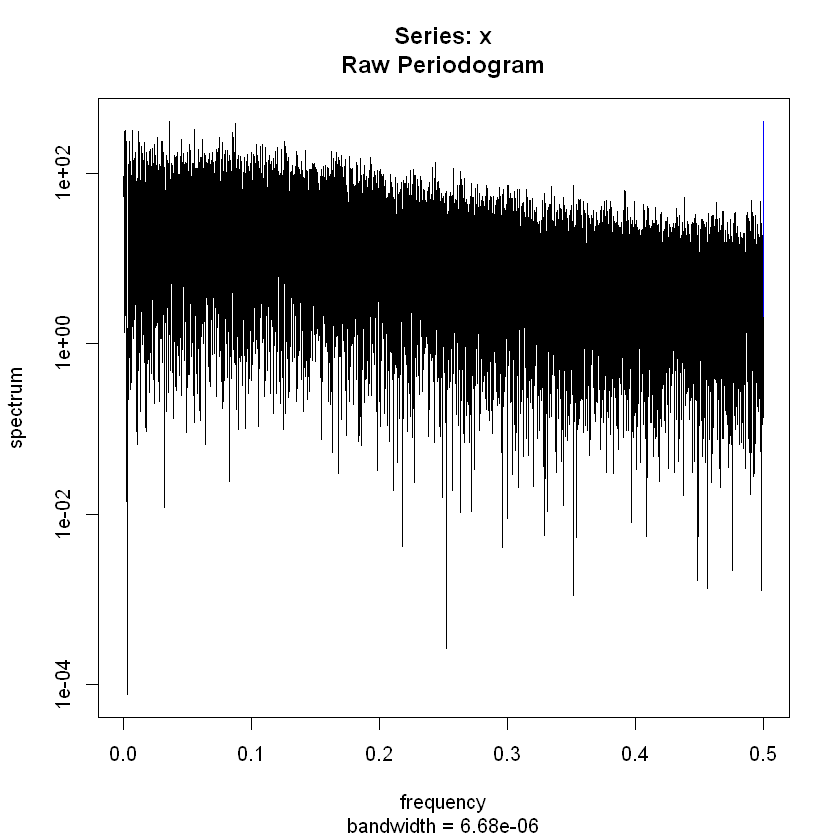

In [11]:
spectrum(filtered_data$MaxTemp)

Successful! 

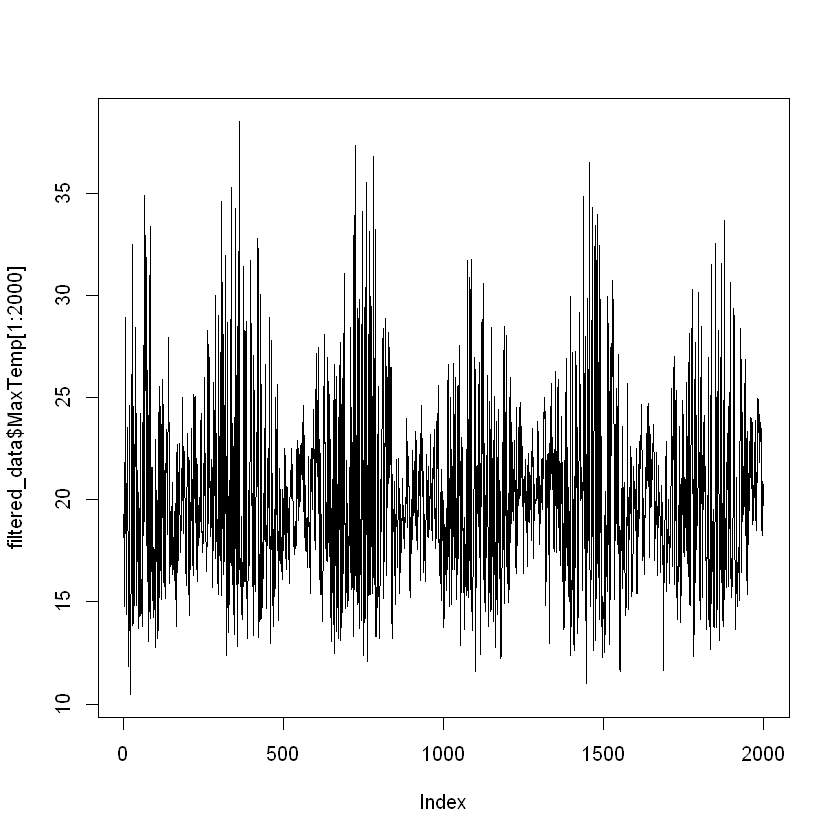

In [12]:
plot(filtered_data$MaxTemp[1:2000], type = 'l')

Varying variance, but seems to be periodic and dependent on time!

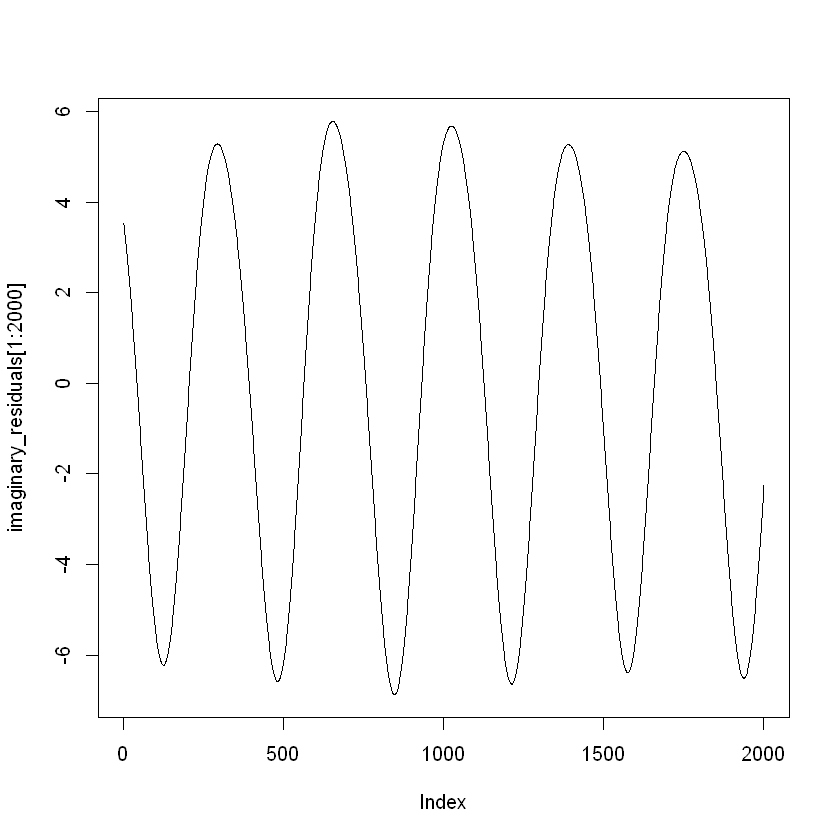

In [13]:
plot(imaginary_residuals[1:2000], type = 'l')

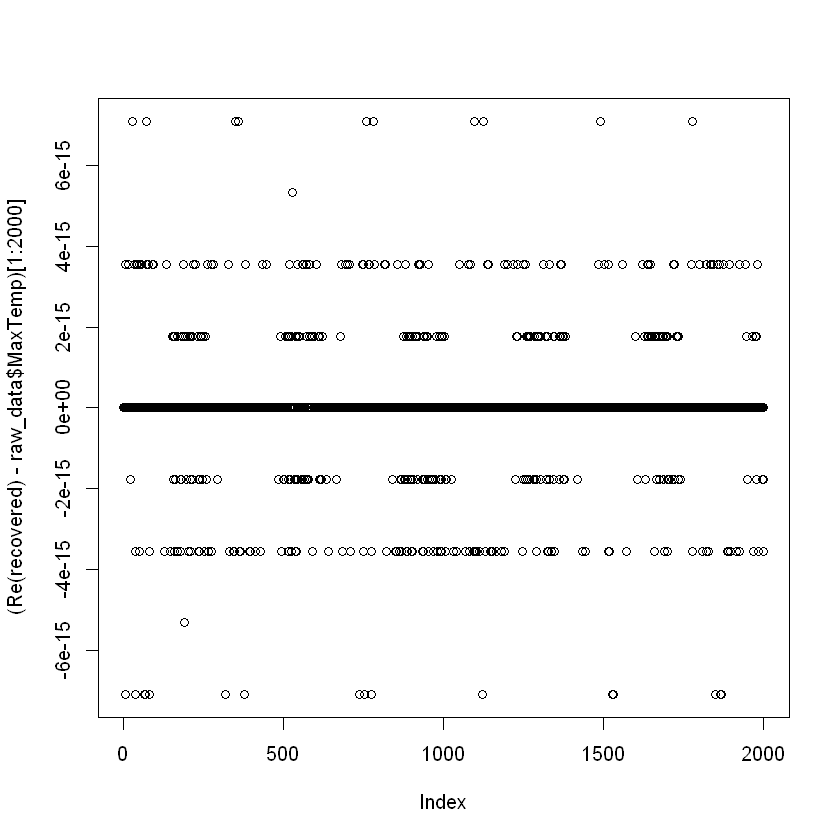

In [14]:
recovered = complex(imaginary = imaginary_residuals, real = filtered_data$MaxTemp) + annual_osc + biannual_osc
plot((Re(recovered) - raw_data$MaxTemp)[1:2000])

Good! When we try to recover the original data, the error between recovered vs raw is very small! 

# Approach 1: Group by day

From previous visualizations, we note that the variance of our time series seems to be dependent on time. 

In [15]:
daily_normalized_data = data.frame(filtered_data)

In [16]:
grouped_daily_var = aggregate(MaxTemp ~ Month*Day, daily_normalized_data, FUN = var)
grouped_daily_var = grouped_daily_var[order(grouped_daily_var$Month, grouped_daily_var$Day), ]
grouped_daily_avg = aggregate(MaxTemp ~ Month*Day, daily_normalized_data, FUN = mean)
grouped_daily_avg = grouped_daily_avg[order(grouped_daily_avg$Month, grouped_daily_avg$Day), ]

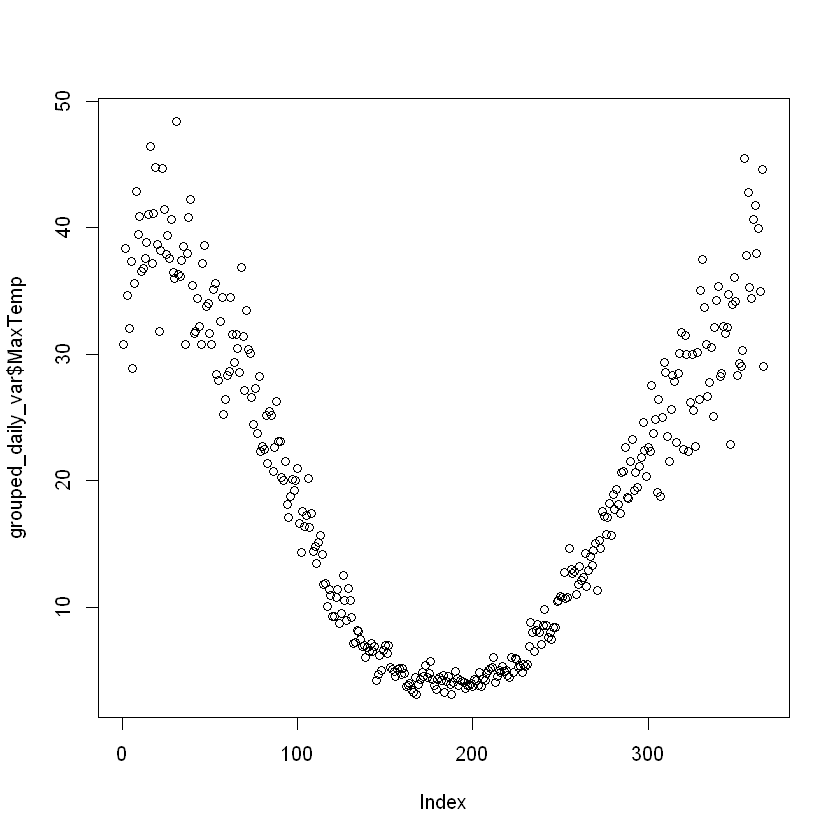

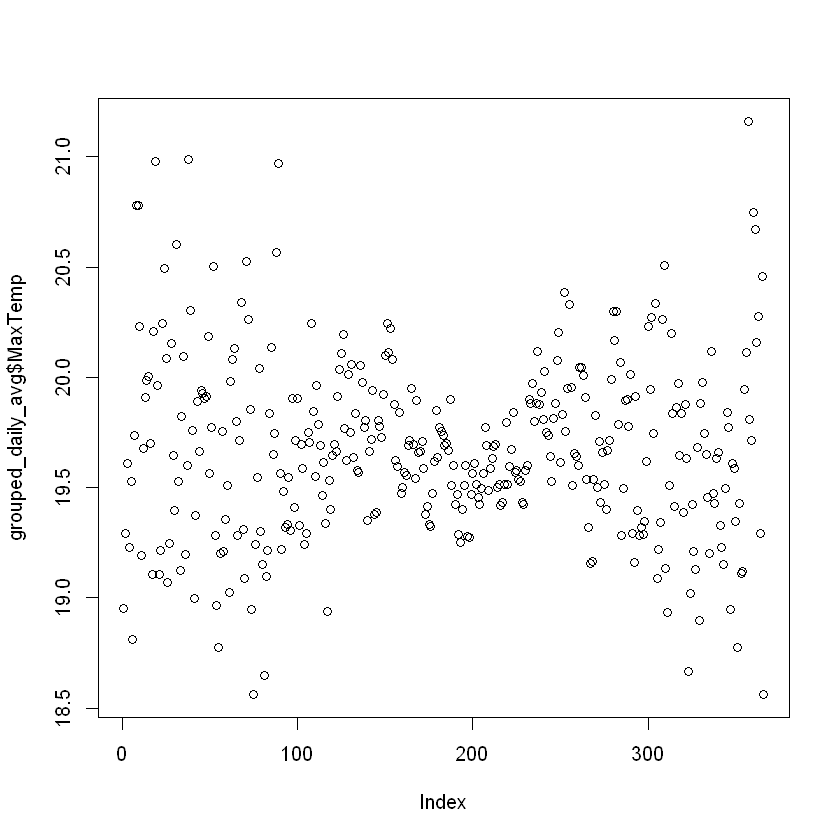

In [17]:
plot(grouped_daily_var$MaxTemp)
plot(grouped_daily_avg$MaxTemp)

## Using for loop to normalize the data

In [18]:
for (row in c(1: nrow(daily_normalized_data))){
    month = daily_normalized_data[row, 2]
    day = daily_normalized_data[row, 3]
    variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
    mean = grouped_daily_avg[ which(grouped_daily_avg$Month == month & grouped_daily_avg$Day == day), ]$MaxTemp
    daily_normalized_data[row, 4] = (daily_normalized_data[row, 4] - mean )/ sqrt(variance)
}

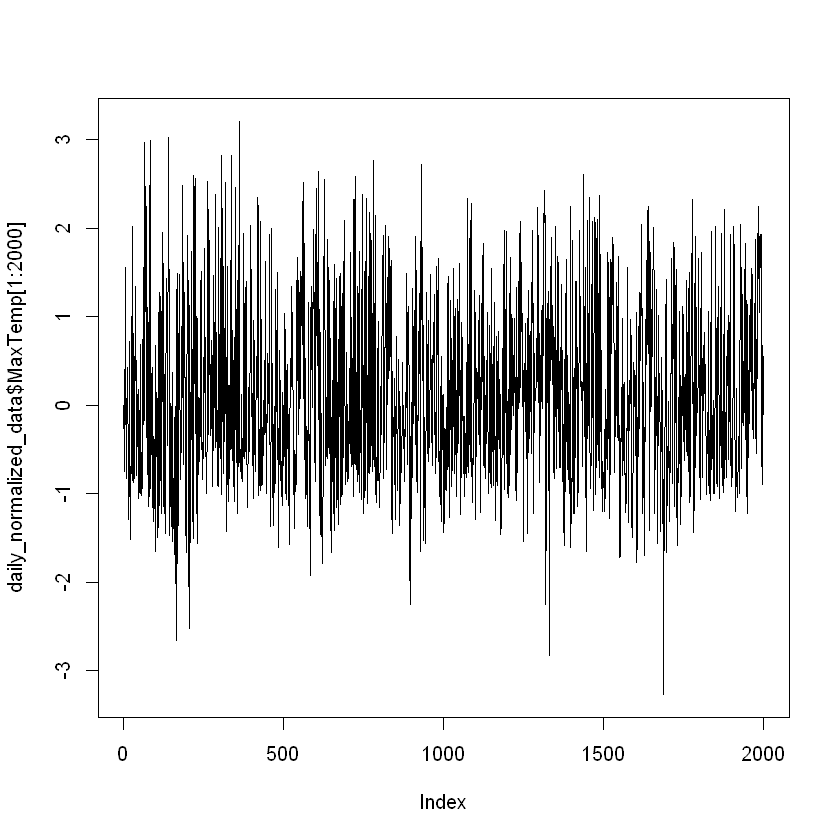

In [19]:
plot(daily_normalized_data$MaxTemp[1:2000], type = 'l')

We seem to be able to reduce some of the variance, but regular spikes are still clearly visible.

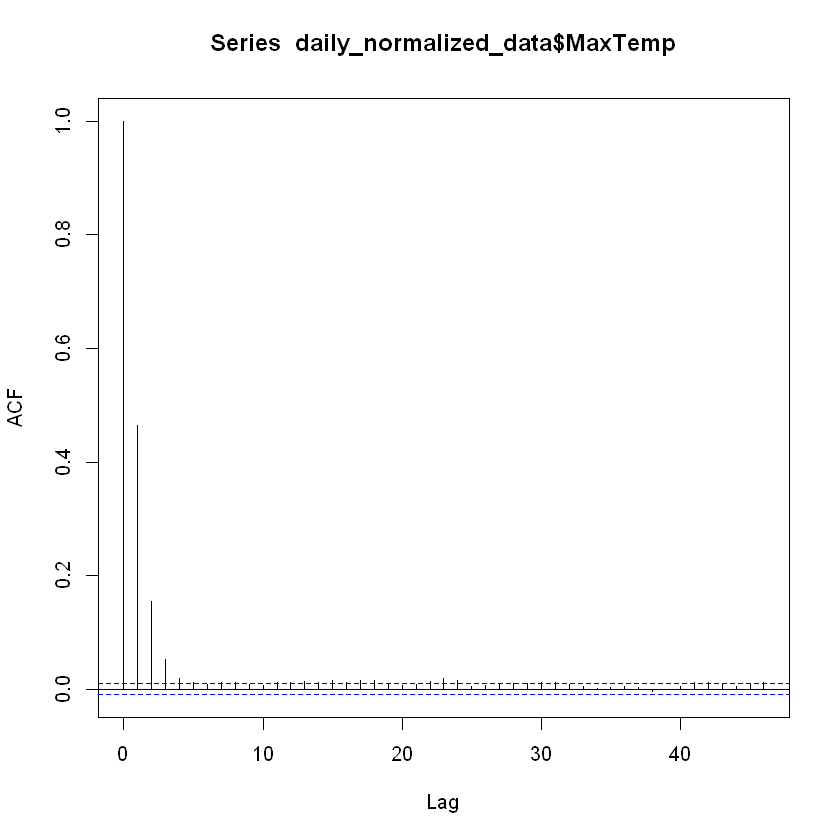

In [20]:
acf(daily_normalized_data$MaxTemp)

# Approach 2: Group by month

In [21]:
monthly_normalized_data = data.frame(filtered_data)

In [22]:
rm(mean)

grouped_monthly_var = aggregate(MaxTemp ~ Month, monthly_normalized_data, FUN = var)
grouped_monthly_var = grouped_monthly_var[order(grouped_monthly_var$Month), ]
grouped_monthly_avg = aggregate(MaxTemp ~ Month, monthly_normalized_data, FUN = mean)
grouped_monthly_avg = grouped_monthly_avg[order(grouped_monthly_avg$Month), ]

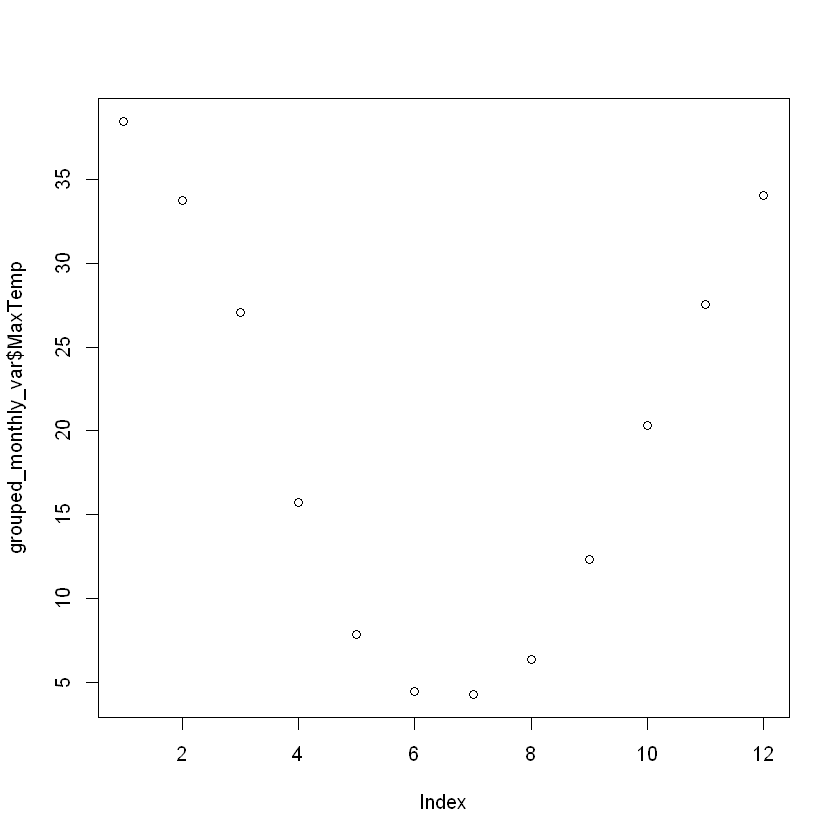

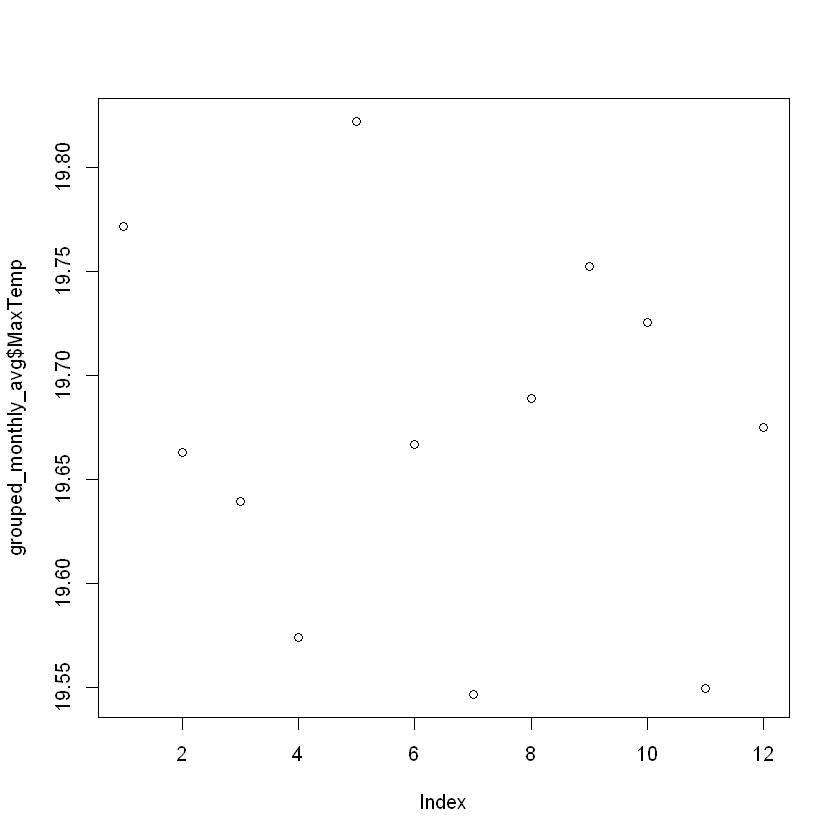

In [23]:
plot(grouped_monthly_var$MaxTemp)
plot(grouped_monthly_avg$MaxTemp)

## Using for loop to normalize the data

In [24]:
for (row in c(1: nrow(monthly_normalized_data))){
    month = monthly_normalized_data[row, 2]
    variance = grouped_monthly_var[ which(grouped_monthly_var$Month == month), ]$MaxTemp
    mean = grouped_monthly_avg[ which(grouped_monthly_avg$Month == month), ]$MaxTemp
    monthly_normalized_data[row, 4] = (monthly_normalized_data[row, 4] - mean )/ sqrt(variance)
}

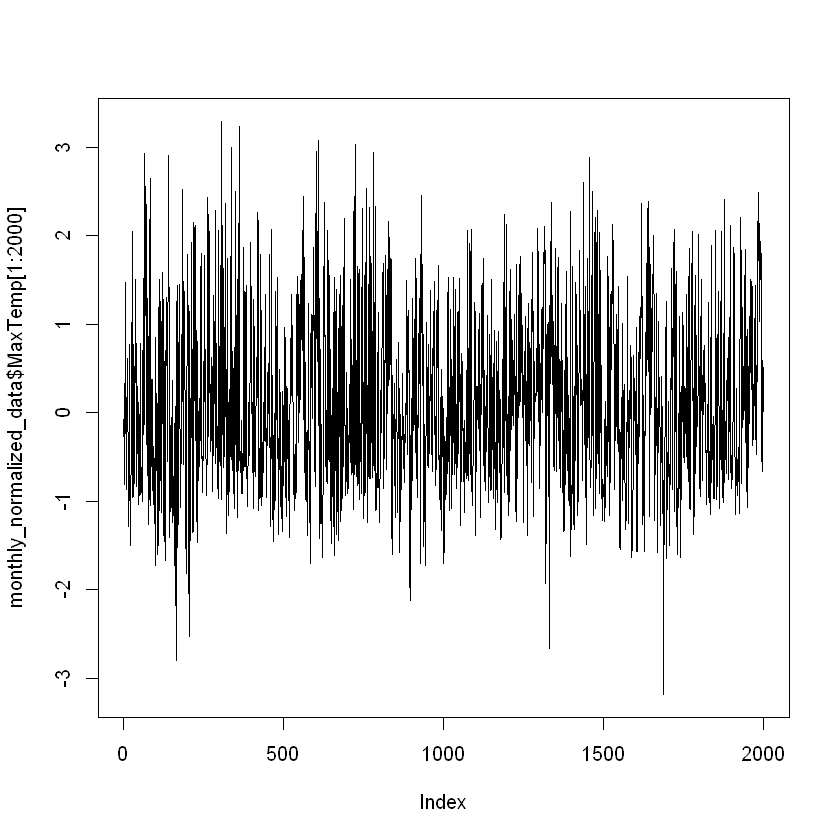

In [25]:
plot(monthly_normalized_data$MaxTemp[1:2000], type = 'l')

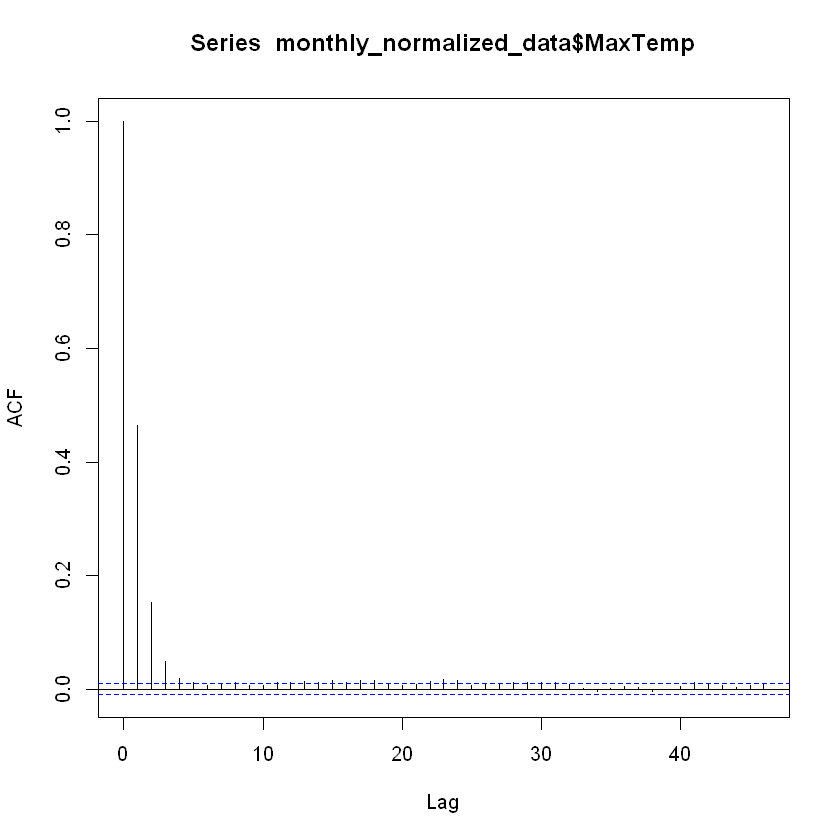

In [26]:
acf(monthly_normalized_data$MaxTemp)

# Approach 3: Normalize using daily mean and monthly variance

In [27]:
daily_monthly_normalized_data = data.frame(filtered_data)

In [28]:
for (row in c(1: nrow(daily_monthly_normalized_data))){
    month = daily_monthly_normalized_data[row, 2]
    day = daily_monthly_normalized_data[row, 3]
    variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
    mean = grouped_monthly_avg[ which(grouped_monthly_avg$Month == month), ]$MaxTemp
    daily_monthly_normalized_data[row, 4] = (daily_monthly_normalized_data[row, 4] - mean )/ sqrt(variance)
}

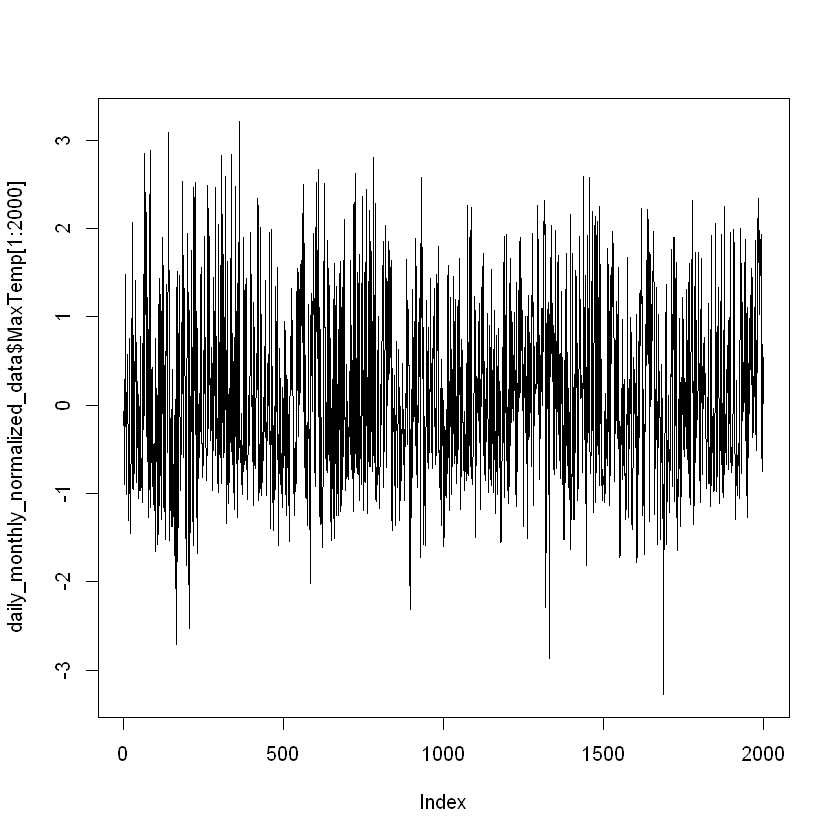

In [36]:
plot(daily_monthly_normalized_data$MaxTemp[1:2000], type = 'l')

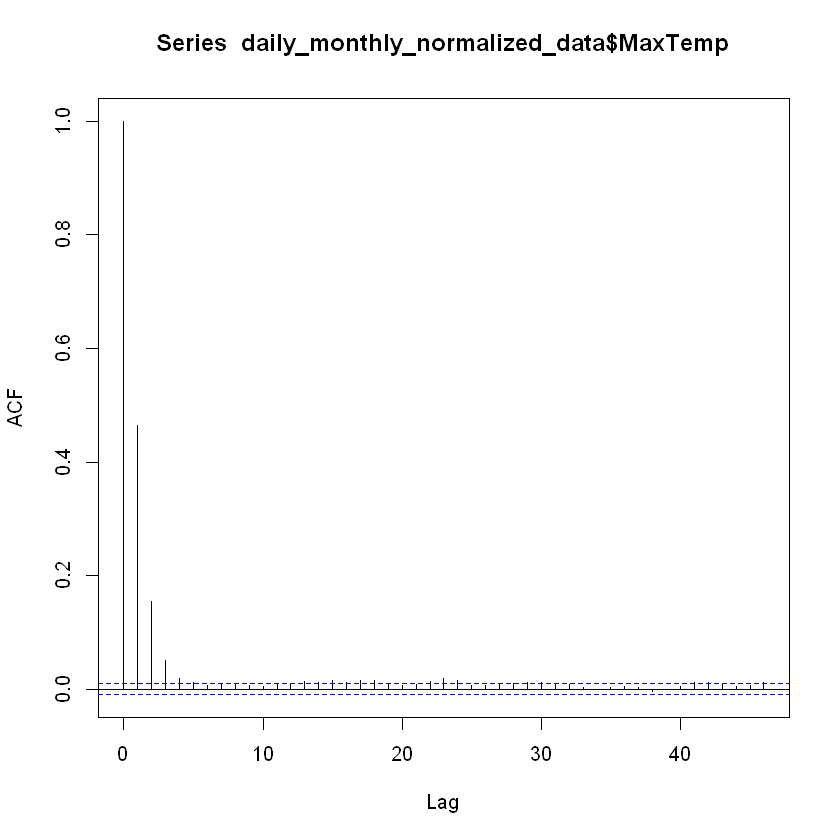

In [146]:
acf(daily_monthly_normalized_data$MaxTemp)

In [31]:
install.packages("roll", repos = "http://cran.us.r-project.org") 

Installing package into 'C:/Users/emara/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'roll' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\emara\AppData\Local\Temp\RtmpwxFLlm\downloaded_packages


# Evaluation

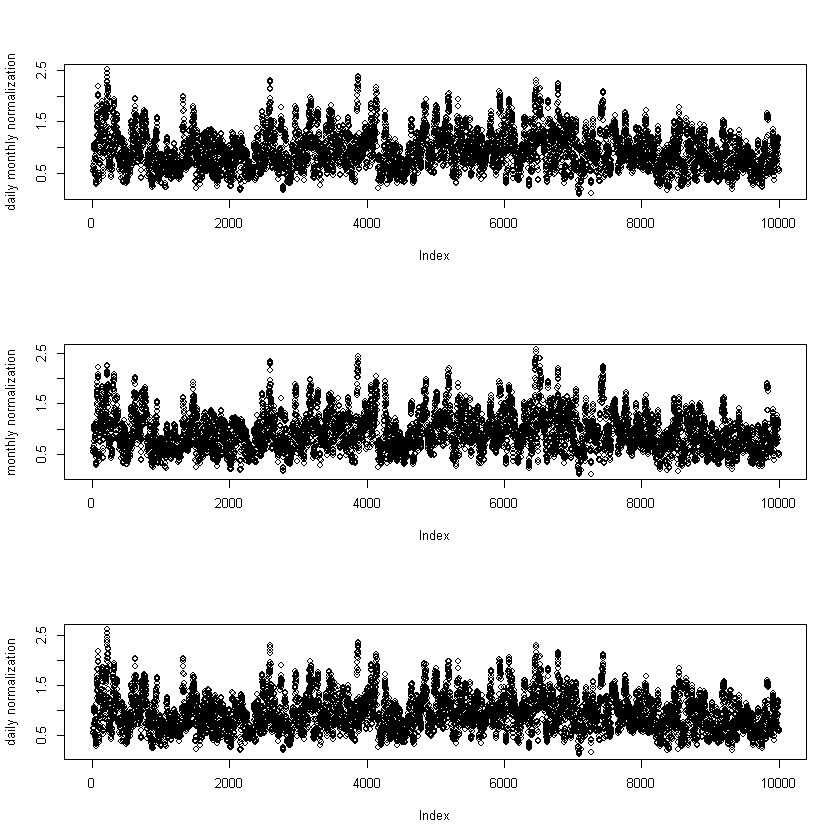

In [34]:
layout(matrix(3:1,nrow=3))
plot(roll::roll_var(matrix(daily_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "daily normalization")
plot(roll::roll_var(matrix(monthly_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "monthly normalization")
plot(roll::roll_var(matrix(daily_monthly_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "daily monthly normalization")

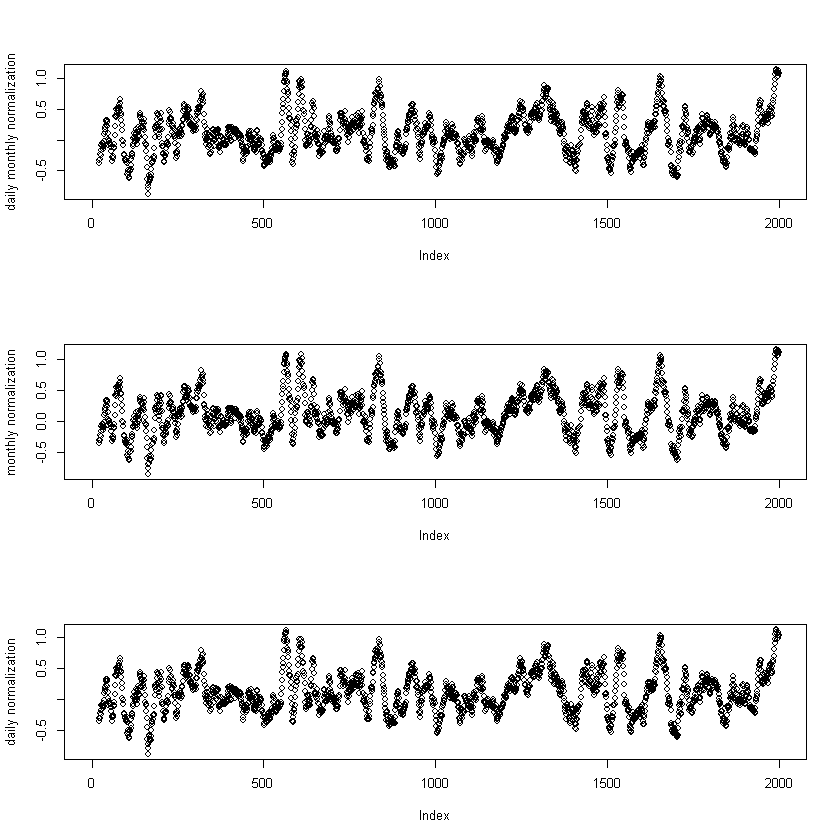

In [33]:
layout(matrix(3:1,nrow=3))
plot(roll::roll_mean(matrix(daily_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "daily normalization")
plot(roll::roll_mean(matrix(monthly_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "monthly normalization")
plot(roll::roll_mean(matrix(daily_monthly_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "daily monthly normalization")

Best one seems to be monthly normalization, by a very small margin. 

# Fitting a model to the remainder
## AR(2)

In [83]:
ts = ts(daily_normalized_data$MaxTemp, frequency = 365)
head(ts)

[1] -0.004104783 -0.517039328 -0.171338183 -0.752515227  1.552664123
[6] -0.213510811

In [192]:
ts_lag1 = lag(ts,-1) 
ts_lag2 = lag(ts,-2) 
ts_lag3 = lag(ts,-3) 
ts_lag4 = lag(ts,-4) 
ts_lag5 = lag(ts,-5) 
ts_lag6 = lag(ts,-6)
ts_lag7 = lag(ts,-7)
ts_lag8 = lag(ts,-8) 
ts_lag9 = lag(ts,-9) 
ts_lag10 = lag(ts,-10) 
ts_lag11 = lag(ts,-11) 
ts_lag12 = lag(ts,-12) 
ts_lag13 = lag(ts,-13) 
ts_lag14 = lag(ts,-14) 

In [193]:
y = cbind(ts, ts_lag1)
y = cbind(y, ts_lag2)
y = cbind(y, ts_lag3)
y = cbind(y, ts_lag4)
y = cbind(y, ts_lag5)
y = cbind(y, ts_lag6)
y = cbind(y, ts_lag7)
y = cbind(y, ts_lag8)
y = cbind(y, ts_lag9)
y = cbind(y, ts_lag10)
y = cbind(y, ts_lag11)
y = cbind(y, ts_lag12)
y = cbind(y, ts_lag13)
y = cbind(y, ts_lag14)

In [194]:
head(y)

y.y.y.y.y.y.y.y.y.y.y.y.y.ts,y.y.y.y.y.y.y.y.y.y.y.y.y.ts_lag1,y.y.y.y.y.y.y.y.y.y.y.y.ts_lag2,y.y.y.y.y.y.y.y.y.y.y.ts_lag3,y.y.y.y.y.y.y.y.y.y.ts_lag4,y.y.y.y.y.y.y.y.y.ts_lag5,y.y.y.y.y.y.y.y.ts_lag6,y.y.y.y.y.y.y.ts_lag7,y.y.y.y.y.y.ts_lag8,y.y.y.y.y.ts_lag9,y.y.y.y.ts_lag10,y.y.y.ts_lag11,y.y.ts_lag12,y.ts_lag13,ts_lag14
-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.552664123,-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.213510811,1.552664123,-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [205]:
ar1fit = lm(y[,1] ~ y[,2])
ar2fit = lm(y[,1] ~ y[,2] + y[,3])
ar3fit = lm(y[,1] ~ y[,2] + y[,3] + y[, 4])
complex_model = lm(y[,1] ~ (y[,2] + y[,3] + y[, 4] + y[, 5] + y[, 6] + y[, 7] + y[, 8] + y[, 9] + y[, 10] + y[, 11] + y[, 12] + y[, 13] +y[, 14] )^3)

In [200]:
summary(ar3fit)


Call:
lm(formula = y[, 1] ~ y[, 2] + y[, 3] + y[, 4])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7706 -0.5973 -0.1024  0.6000  3.5583 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.160e-08  4.273e-03   0.000  0.99999    
y[, 2]       5.012e-01  4.860e-03 103.135  < 2e-16 ***
y[, 3]      -8.373e-02  5.421e-03 -15.445  < 2e-16 ***
y[, 4]       1.279e-02  4.860e-03   2.632  0.00849 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8792 on 42333 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.2204,	Adjusted R-squared:  0.2204 
F-statistic:  3990 on 3 and 42333 DF,  p-value: < 2.2e-16


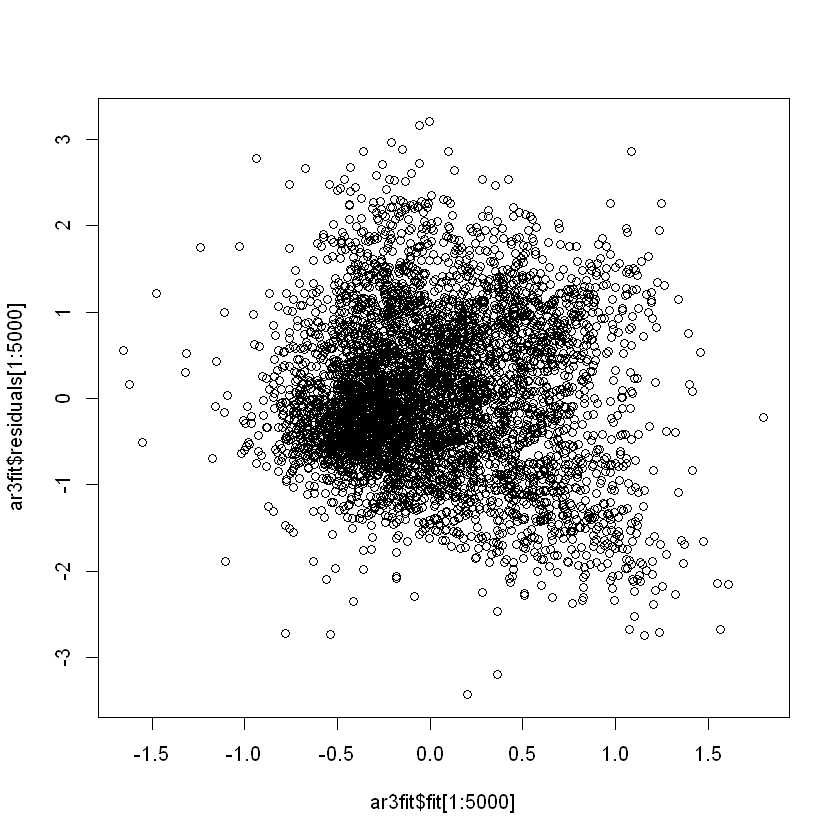

In [138]:
plot(ar3fit$fit[1:5000], ar3fit$residuals[1:5000])

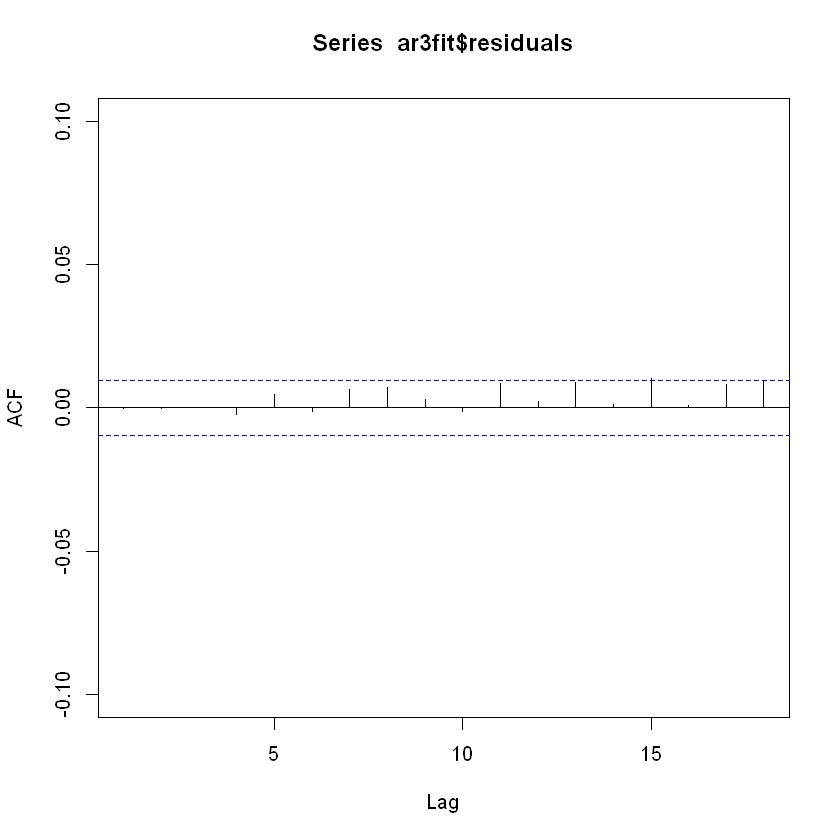

In [143]:
acf(ar3fit$residuals, xlim=c(1,18), ylim = c(-0.1, 0.1))

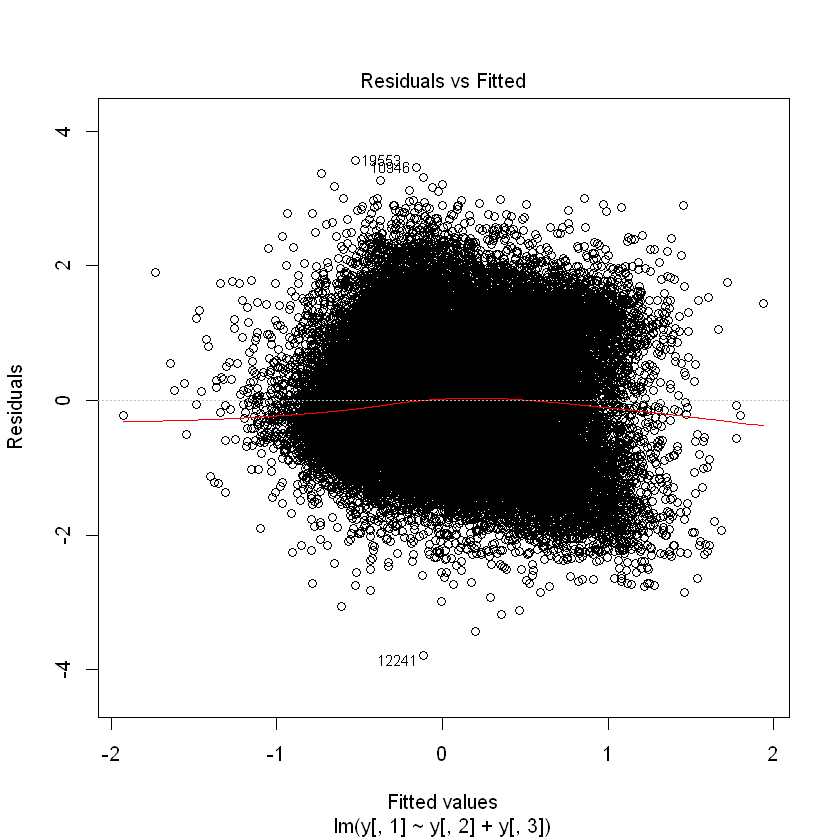

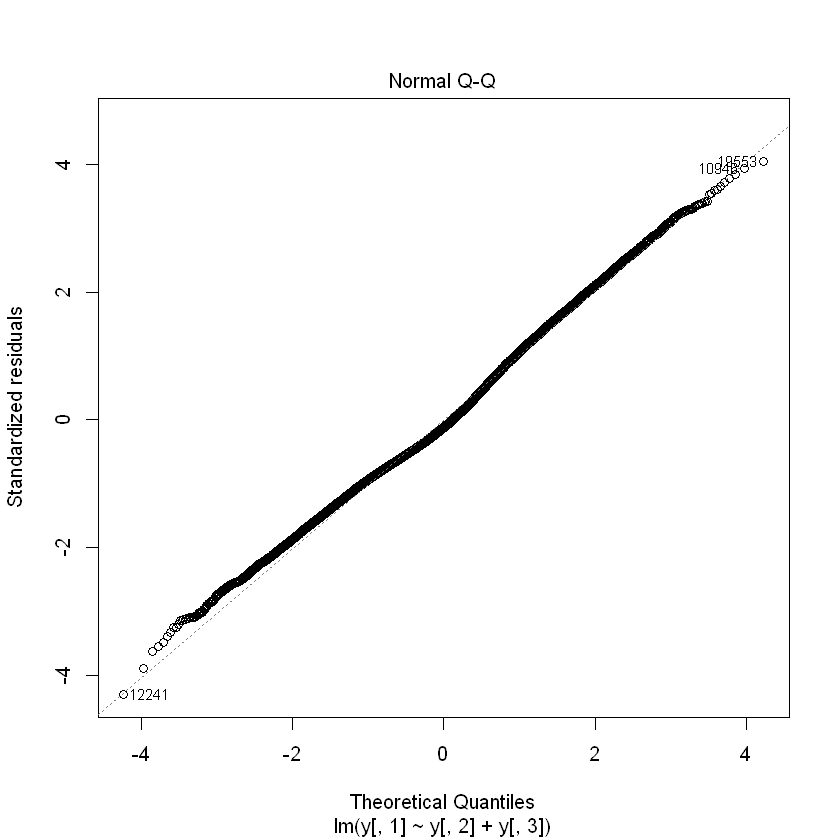

In [115]:
plot(ar2fit, which = 1)
plot(ar2fit, which = 2)

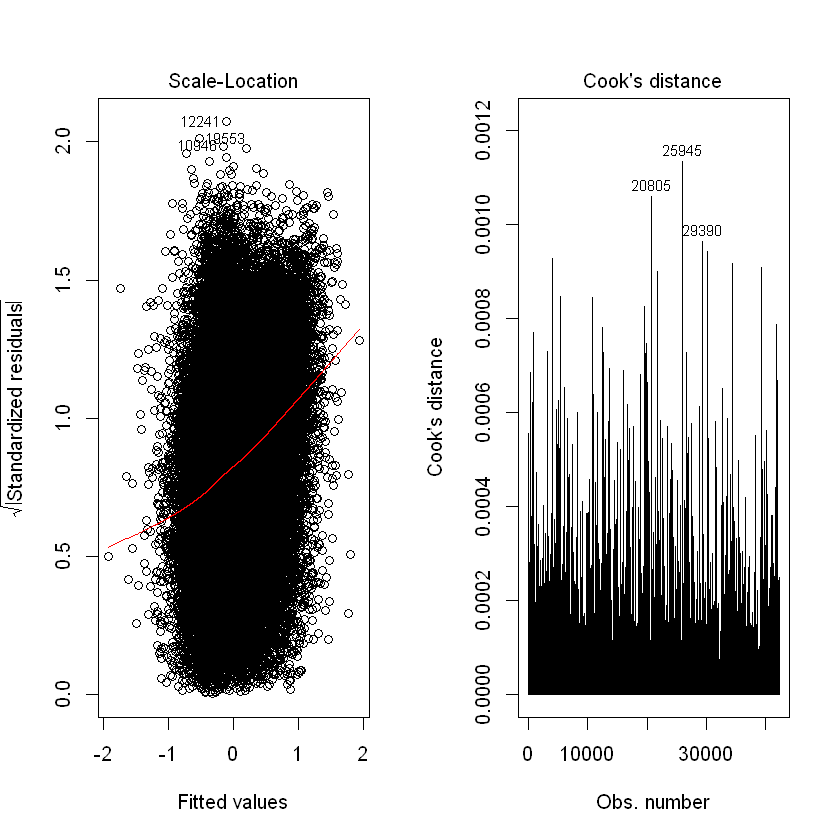

In [116]:
layout(matrix(1:2,ncol=2))
plot(ar2fit, which = 3)
plot(ar2fit, which = 4)

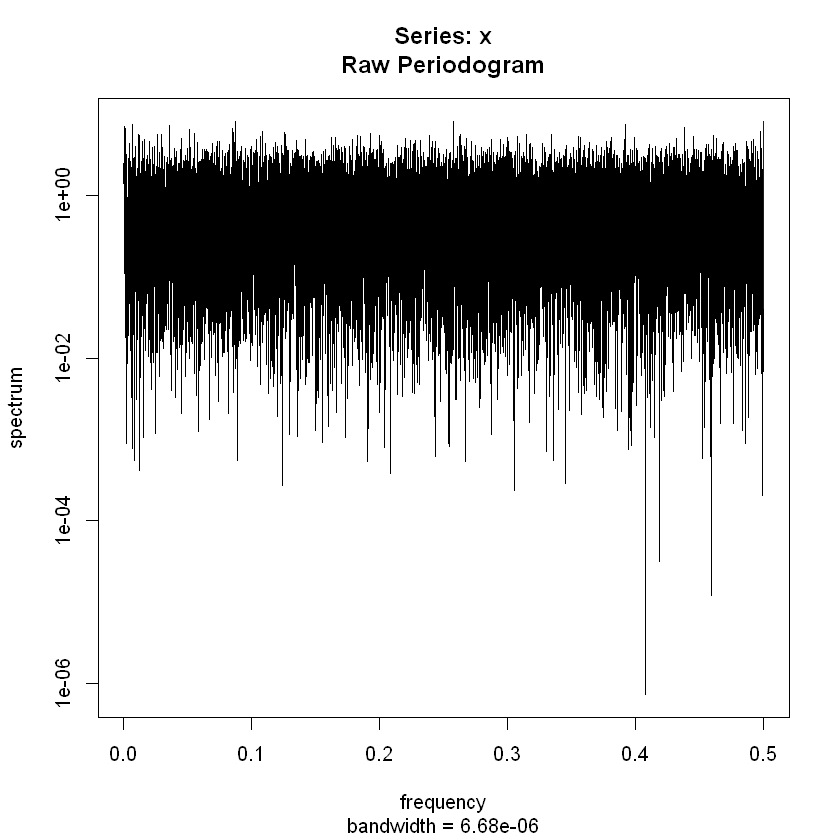

In [107]:
spectrum(ar2fit$residuals)

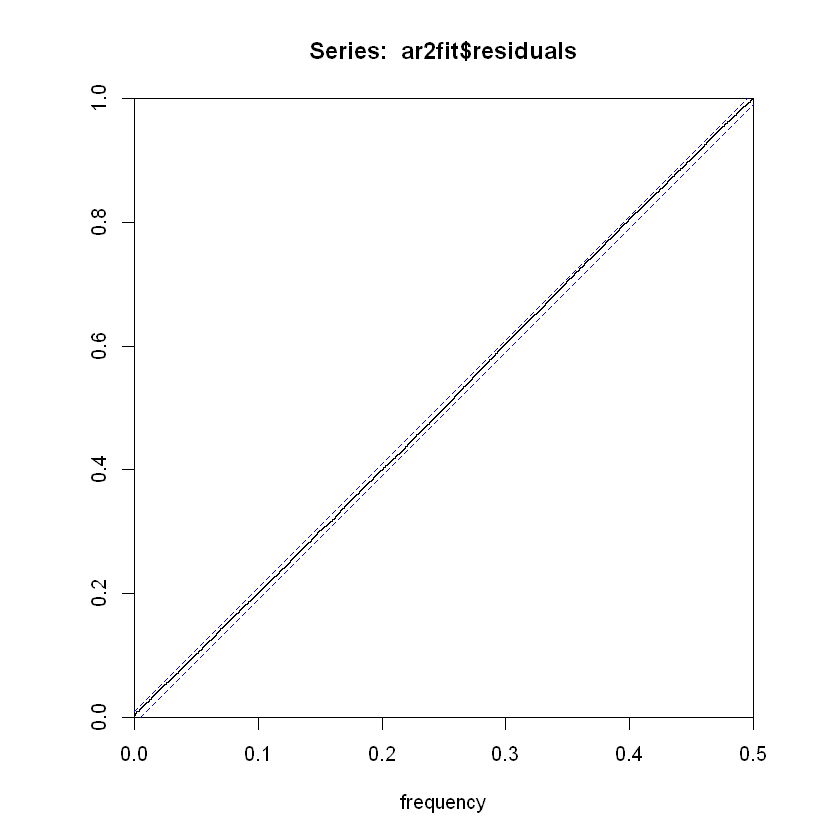

In [136]:
cpgram(ar2fit$residuals)

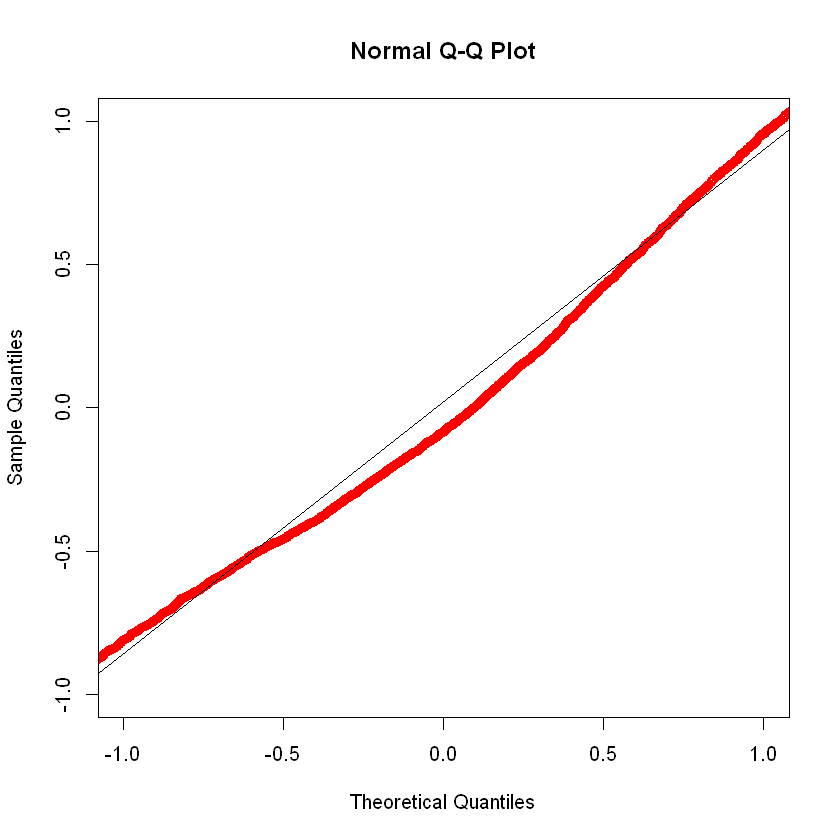

In [144]:
qqnorm(ar3fit$residuals[1:5000], col = 'red', ylim = c(-1, 1), xlim = c(-1, 1))
qqline(ar3fit$residuals[1:5000])

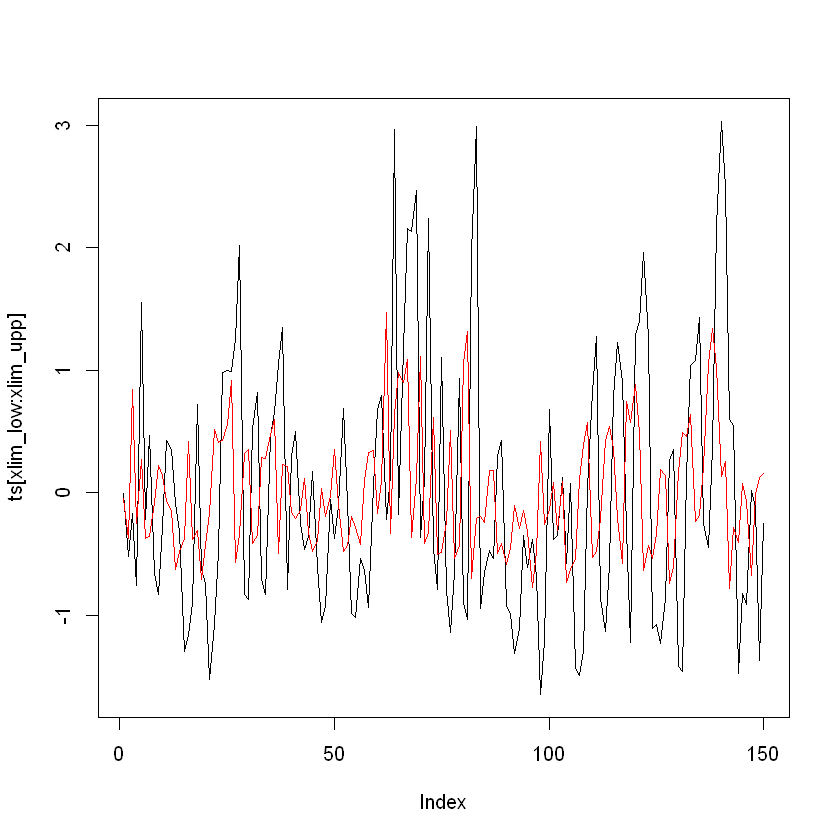

In [168]:
xlim_low = 1
xlim_upp = 150
plot(ts[xlim_low:xlim_upp], type = 'l')
lines(c(xlim_low:xlim_upp), ar3fit$fit[xlim_low:xlim_upp], col = 'red')

In [206]:
summary(complex_model)


Call:
lm(formula = y[, 1] ~ (y[, 2] + y[, 3] + y[, 4] + y[, 5] + y[, 
    6] + y[, 7] + y[, 8] + y[, 9] + y[, 10] + y[, 11] + y[, 12] + 
    y[, 13] + y[, 14])^3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0056 -0.5941 -0.1015  0.5916  3.5941 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              2.853e-02  7.487e-03   3.811 0.000139 ***
y[, 2]                   4.976e-01  8.137e-03  61.149  < 2e-16 ***
y[, 3]                  -7.908e-02  8.808e-03  -8.978  < 2e-16 ***
y[, 4]                   1.407e-02  8.804e-03   1.598 0.109952    
y[, 5]                  -5.735e-03  8.831e-03  -0.649 0.516093    
y[, 6]                   1.391e-02  8.823e-03   1.577 0.114807    
y[, 7]                  -1.621e-02  8.824e-03  -1.837 0.066230 .  
y[, 8]                   1.707e-02  8.833e-03   1.933 0.053282 .  
y[, 9]                   1.440e-02  8.895e-03   1.619 0.105495    
y[, 10]                 -5.175e-03  8.866e-03  -0.584 0.5

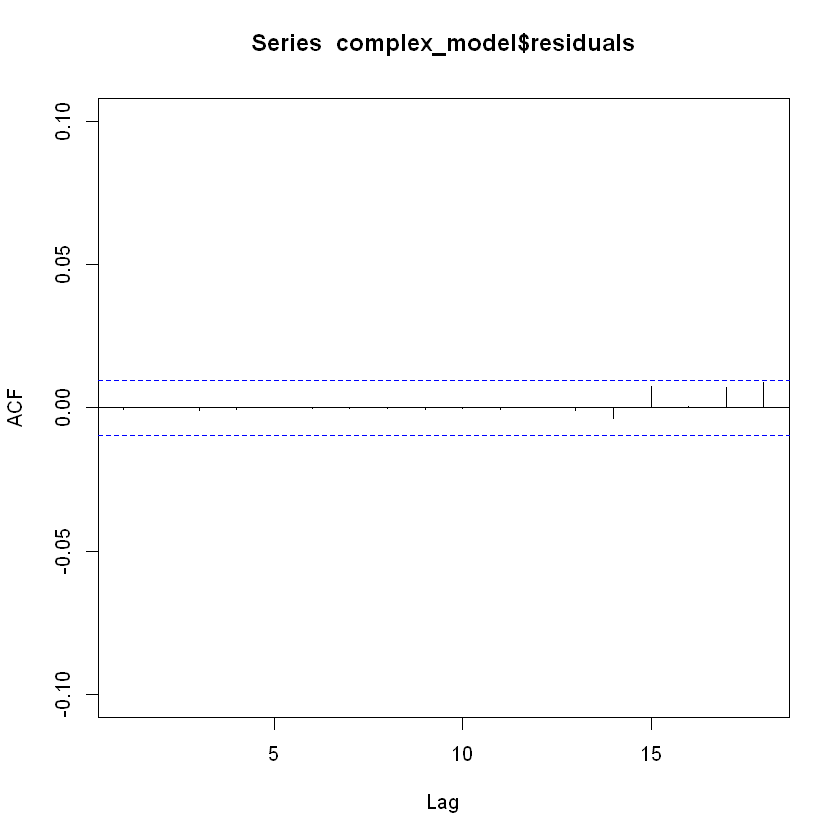

In [207]:
acf(complex_model$residuals, xlim=c(1,18), ylim = c(-0.1, 0.1))

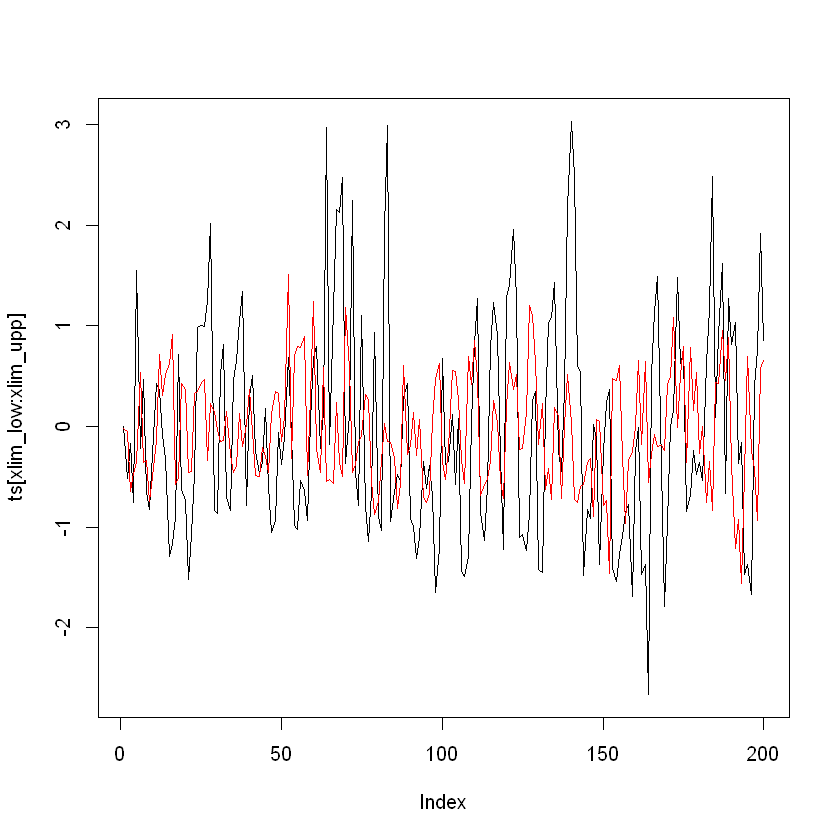

In [210]:
xlim_low = 1
xlim_upp = 200
plot(ts[xlim_low:xlim_upp], type = 'l')
lines(c(xlim_low:xlim_upp), complex_model$fit[xlim_low:xlim_upp], col = 'red')

In [204]:
sqrt(mean((complex_model$residual)^2))

[1] 0.8765334